In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
import pickle

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from math import sqrt

def root_mean_squared_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

## Question 1. Downloading the data (1 point)

In [30]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

print(f"Number of columns in January 2023 data: {len(df.columns)}")
print(f"Columns: {df.columns.tolist()}")

# Display a few rows to understand the data
df.head()

Number of columns in January 2023 data: 19
Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


## Q2. Computing duration

In [33]:
df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60
duration_std = df.duration.std()
print(f"Standard deviation of trip duration: {duration_std:.2f} minutes")

Standard deviation of trip duration: 42.59 minutes


## Q3. Dropping outliers

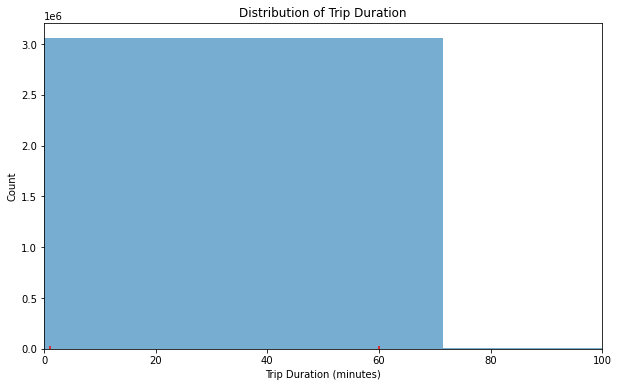

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(df.duration, bins=100, alpha=0.6)
plt.vlines(x=[1, 60], ymin=0, ymax=25000, colors='r', linestyles='dashed')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Trip Duration')
plt.xlim(0, 100)
plt.show()

In [37]:
original_count = len(df)

# Filter records with duration between 1 and 60 minutes
df_jan_filtered = df[(df.duration >= 1) & (df.duration <= 60)]
filtered_count = len(df_jan_filtered)

# Calculate the fraction of records kept
fraction_kept = filtered_count / original_count

print(f"Original number of records: {original_count}")
print(f"Number of records after filtering: {filtered_count}")
print(f"Fraction of records kept: {fraction_kept:.4f} ({fraction_kept*100:.2f}%)")

Original number of records: 3066766
Number of records after filtering: 3009173
Fraction of records kept: 0.9812 (98.12%)


## Q4. One-hot encoding

In [38]:
df = df_jan_filtered

categorical = ['PULocationID', 'DOLocationID']

df[categorical] = df[categorical].astype(str)

train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f"Feature matrix shape: {X_train.shape}")
print(f"Number of columns (dimensionality): {X_train.shape[1]}")

Feature matrix shape: (3009173, 515)
Number of columns (dimensionality): 515


## Q5. Training a model

In [39]:
# Get target variable
y_train = df.duration.values

# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on training data
y_pred = lr.predict(X_train)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_train, y_pred))
print(f"RMSE on training data: {rmse:.2f}")

RMSE on training data: 7.65


## Q6. Evaluating the model

In [40]:
# Read February 2023 data
df_feb = pd.read_parquet('data/yellow_tripdata_2023-02.parquet')

# Compute duration
df_feb['duration'] = (df_feb.tpep_dropoff_datetime - df_feb.tpep_pickup_datetime).dt.total_seconds() / 60

# Filter records with duration between 1 and 60 minutes
df_feb_filtered = df_feb[(df_feb.duration >= 1) & (df_feb.duration <= 60)]

# Convert IDs to strings
df_feb_filtered[categorical] = df_feb_filtered[categorical].astype(str)

# Turn dataframe into list of dictionaries
val_dicts = df_feb_filtered[categorical].to_dict(orient='records')

# Transform using the same DictVectorizer
X_val = dv.transform(val_dicts)

# Get target variable
y_val = df_feb_filtered.duration.values

# Make predictions
y_pred_val = lr.predict(X_val)

# Calculate RMSE
rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE on validation data: {rmse_val:.2f}")

/tmp/ipykernel_17834/263371617.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feb_filtered[categorical] = df_feb_filtered[categorical].astype(str)


RMSE on validation data: 7.81
